In [ ]:
import os
import random
import time
import json
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

In [49]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
def load_json_dataset(datset_path='../input/data',json_file='train_all.json'):
    anns_file_path = dataset_path + '/' + json_file
    # Read annotations
    with open(anns_file_path, 'r') as f:
        dataset = json.loads(f.read())
    return dataset

def split_cate_ann_img(dataset):
    return dataset['categories'],dataset['annotations'],dataset['images']

In [50]:
dataset_train=load_json_dataset('../input/data','train.json')
dataset_valid=load_json_dataset('../input/data','val.json')
dataset_test=load_json_dataset('../input/data','test.json')

In [51]:
tr_cate,tr_ann,tr_img=split_cate_ann_img(dataset_train)
val_cate,val_ann,val_img=split_cate_ann_img(dataset_valid)
test_cate,test_ann,test_img=split_cate_ann_img(dataset_test)

In [52]:
tr_img[0]['file_name']

'batch_01_vt/0003.jpg'

In [53]:
category_names = category_names = ['Backgroud','General trash','Paper','Paper pack',
                  'Metal','Glass','Plastic','Styrofoam','Plastic bag',
                  'Battery','Clothing']

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        #index값에 맞는 이미지 읽음
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)#bgr->rgb
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            #마스크를 위한 빈 배열 생성
            
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            #면적이 큰 순서대로 정리
            
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [54]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1,
                                           collate_fn=collate_fn,
                                           shuffle=False,
                                           drop_last=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=1,
                                           collate_fn=collate_fn,
                                           shuffle=False,
                                           drop_last=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=1,
                                           collate_fn=collate_fn,
                                           shuffle=False,
                                           drop_last=False)

loading annotations into memory...
Done (t=4.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [55]:
class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [56]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [57]:
import shutil

In [85]:
# train_loader의 output 결과(image 및 mask) 확인
for idx,(imgs, masks, image_infos) in enumerate(train_loader):
    image_infos = image_infos[0]
    # break
    # shutil.copyfile(os.path.join(dataset_path,image_infos['file_name']),
    #                ('../input/mmseg/img_dir/train/'+image_infos['file_name'].replace('/','_')))
    # temp_images = imgs
    # plt.imsave('../input/mmseg/ann_dir_png/train/'+image_infos['file_name'].replace('/','_').replace('jpg','png'),label_to_color_image(masks[0].detach().cpu().numpy()))
    # plt.imsave('../input/mmseg/ann_imsave/train/'+image_infos['file_name'].replace('/','_').replace('jpg','png'),masks[0].numpy())
    cv2.imwrite('../input/mmseg/ann_imwrite/train/'+image_infos['file_name'].replace('/','_').replace('jpg','png'), masks[0].numpy())

In [86]:
# train_loader의 output 결과(image 및 mask) 확인
for idx,(imgs, masks, image_infos) in enumerate(val_loader):
    image_infos = image_infos[0]
    # shutil.copyfile(os.path.join(dataset_path,image_infos['file_name']),
    #                ('../input/mmseg/img_dir/val/'+image_infos['file_name'].replace('/','_')))
    # temp_images = imgs
    # plt.imsave('../input/mmseg/ann_dir_png/val/'+image_infos['file_name'].replace('/','_').replace('jpg','png'),label_to_color_image(masks[0].detach().cpu().numpy()))
    # plt.imsave('../input/mmseg/ann_dir_png_npy/val/'+image_infos['file_name'].replace('/','_').replace('jpg','png'),masks[0].numpy())
    cv2.imwrite('../input/mmseg/ann_imwrite/val/'+image_infos['file_name'].replace('/','_').replace('jpg','png'), masks[0].numpy())

In [68]:
# train_loader의 output 결과(image 및 mask) 확인
for idx,(imgs, image_infos) in enumerate(test_loader):
    image_infos = image_infos[0]
    shutil.copyfile(os.path.join(dataset_path,image_infos['file_name']),
                   ('../input/mmseg/img_dir/test/'+image_infos['file_name'].replace('/','_')))

In [74]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmcv import Config

# cfg = Config.fromfile('/opt/ml/semantic-segmentation-level2-cv-07/mmsegmentation/deeplabv4_unet_s5-d16.py')
cfg = Config.fromfile('deeplabv4_unet_s5-d16.py')
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

print('='*30)
print(datasets)
print('='*30)

cfg.seed=2021

2021-10-20 08:47:16,618 - mmseg - INFO - Loaded 2617 images


In [3]:
import numpy as np
colormaㅔnp.zeros((11, 3), dtype=np.uint8)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [10]:
import cv2
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict.csv")

def create_trash_label_colormap():
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_trash_label_colormap()
    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
    return colormap[label]

category_names = ["Backgroud", "General trash", "Paper", "Paper pack",
                  "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag",
                  "Battery", "Clothing"]

palette = [[0,0,0], [192,0,128], [0,128,192], [0,128,64],
           [128,0,0], [64,0,128], [64,0,192] ,[192,128,64],
           [192,192,128], [64,64,128], [128,0,192]]


def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"


In [12]:
coco = COCO('../input/data/test.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [20]:
coco.imgs

819

In [23]:
coco.anns[2]

{'id': 2,
 'image_id': 2,
 'category_id': 0,
 'segmentation': [[1]],
 'area': 1,
 'bbox': [0, 0, 1, 1],
 'iscrowd': 0}

In [35]:
anns

[{'id': 0,
  'image_id': 0,
  'category_id': 0,
  'segmentation': [[1]],
  'area': 1,
  'bbox': [0, 0, 1, 1],
  'iscrowd': 0}]

In [32]:
masks

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
N = len(coco.imgs)
for idx in range(N):
    image_id = coco.getImgIds(imgIds=idx)
    image_infos = coco.loadImgs(image_id)[0]
    
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)
    
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    
    masks = np.zeros((image_infos["height"], image_infos["width"]))
    
    anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
    break
    for ann in anns:
        className = get_classname(ann['category_id'], cats)
        if className == "None":
            pixel_value = 0
        else:
            pixel_value = category_names.index(className)
        print(pixel_value)
        masks[coco.annToMask(ann) == 1] = pixel_value
    masks = masks.astype(np.int8)
    break
    # plt.imsave('./test/ann_rgb/'+ str(idx) + '.png', label_to_color_image(masks))

In [46]:
label_to_color_image(masks[0].detach().cpu().numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [36]:
def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [43]:
label_to_color_image(masks[0][0][0])

IndexError: invalid index to scalar variable.

In [44]:
masks[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [98]:
mmseg=pd.read_csv('/opt/ml/semantic-segmentation-level2-cv-07/mmsegmentation/work_dirs/test/submission_latest.csv')

In [95]:
baseline=pd.read_csv('/opt/ml/segmentation/baseline_code/submission/deeplab_test.csv')

In [153]:
baseline

,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
814,batch_03/0947.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
815,batch_03/0968.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
816,batch_03/0969.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
817,batch_03/0992.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [152]:
mmseg

,image_id,PredictionString
0,batch_01_vt/0021.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,batch_01_vt/0028.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,batch_01_vt/0031.jpg,8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 ...
3,batch_01_vt/0032.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,batch_01_vt/0076.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...
814,batch_03/0947.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
815,batch_03/0968.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
816,batch_03/0969.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
817,batch_03/0992.jpg,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


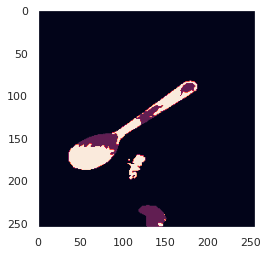

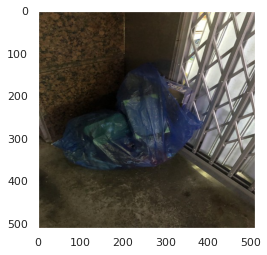

In [150]:
N=3
#====================
x=mmseg["PredictionString"][N]
x=np.array(list(map(int,x.split(' ')))).reshape(256,256)
plt.figure(121)
plt.imshow(x)
images = plt.imread('../input/data/'+mmseg["image_id"][N])
plt.figure(122)
plt.imshow(images)



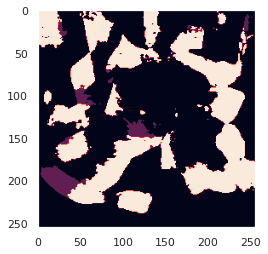

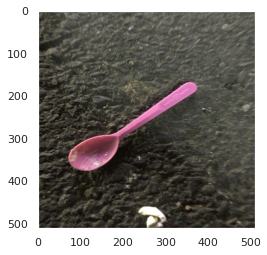

In [151]:
N=2
#====================
x=mmseg["PredictionString"][N]
x=np.array(list(map(int,x.split(' ')))).reshape(256,256)
plt.figure(121)
plt.imshow(x)
images = plt.imread('../input/data/'+mmseg["image_id"][N])
plt.figure(122)
plt.imshow(images)


In [ ]:
plt.imshow

In [ ]:
for 

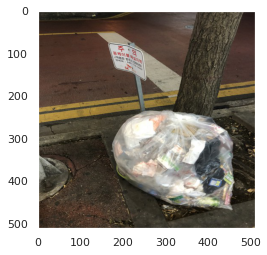

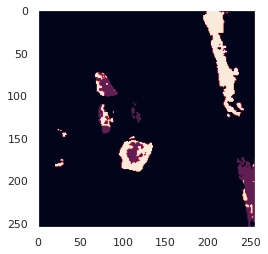

In [128]:
plt.show()



In [123]:
# images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)#bgr->rgb
# images /= 255.0
# semantic-segmentation-level2-cv-07/input/mmseg/img_dir/test/batch_01_vt_0008.jpg

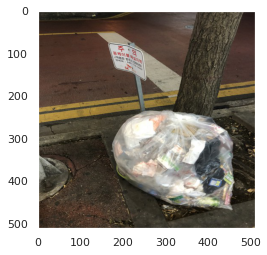